In [1]:
#general & system\n",
import os

#data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = 10, 10  #default setting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#data augmentation
from PIL import Image
from random import choice
import cv2
import numpy as np
#import keras.preprocessing.image as prep

#ML part
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image as kimage
from keras.models import Sequential
from keras.layers import GlobalMaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D,Dropout,Activation,Flatten
from keras.models import Model
from keras.optimizers import SGD
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

#validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc,classification_report,roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc,classification_report,roc_auc_score


from sklearn.metrics import precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

%matplotlib inline

Using TensorFlow backend.


In [2]:
%%time
meta = pd.read_csv("../data/label_learn.csv", sep = ";")

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.84 ms


In [3]:
meta.head()

,name,label
0,0000000.jpg,benign
1,0000002.jpg,malignant
2,0000006.jpg,benign
3,0000008.jpg,benign
4,0000009.jpg,benign


In [4]:
%%time
train_list = os.listdir("../data/resized_train//")
len(train_list) == len(meta.name)

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 4.55 ms


In [5]:
%%time
X_train = np.array([np.array(Image.open("../data/resized_train/"+fname)) for fname in meta.name])
Y_train = [1 if x=="malignant" else 0 for x in meta.label]

CPU times: user 22 s, sys: 2.06 s, total: 24 s
Wall time: 24 s


# Data Preparation 

## Hair removal : 


We proceed following the steps :

- Data acquisition : Select a subset of data with Hair
- RGB to Grayscale conversion – Contrast Enhancement: Convert to Gray scale
- Binarization : Binarize the Image : Convert the image to binary using an adaptive threshold
- Edge Detection : Using Canny edge detector algorithm
- Removal non-hair edges : 
- Hair mask creation : 



## 'Pastille' removal 

In [6]:
from skimage import segmentation

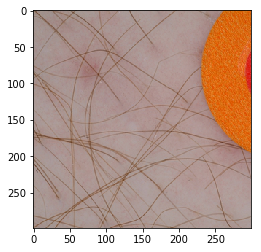

In [95]:
plt.imshow(X_train[3105])

/home/sara_rabhi/anaconda2/lib/python2.7/site-packages/skimage/restoration/non_local_means.py:11: skimage_deprecation: Function ``nl_means_denoising`` is deprecated. Use ``skimage.restoration.denoise_nl_means`` instead.
  multichannel=None, fast_mode=True):


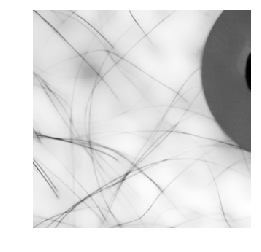

In [96]:
from skimage import morphology
from skimage.feature import peak_local_max
from scipy import ndimage
from skimage import restoration
from skimage import img_as_float

image = X_train[3105]
im_float = img_as_float(image)
im_denoised = restoration.nl_means_denoising(im_float, h=0.05)
im = cv2.cvtColor(im_denoised,cv2.COLOR_BGR2GRAY)
plt.imshow(im, cmap='gray')
ax = plt.axis('off')

In [102]:
import numpy as np
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage import measure
from skimage.segmentation import random_walker
import matplotlib.pyplot as plt
from scipy import ndimage
image = X_train[130]
distance = ndimage.distance_transform_edt(image)
local_maxi = peak_local_max(
    distance, indices=False, labels=image)
markers = measure.label(local_maxi)
labels_ws = watershed(-distance, markers, mask=image)

markers[~image] = -1
labels_rw = random_walker(image, markers)


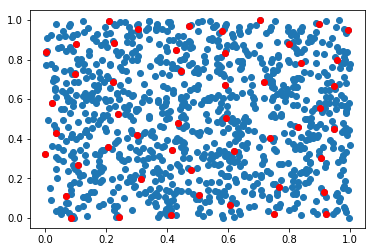

In [82]:
from scipy import spatial

def trim_close_points(points, distance=1):
    """
    Greedy method to remove some points so that
    all points are separated by a distance greater
    than ``distance``.
    
    points : array of shape (2, n_points)
        Coordinates of 2-D points
        
    distance : float
        Minimal distance between points
    """
    x, y = points
    tree = spatial.KDTree(np.array([x, y]).T)
    pairs = tree.query_pairs(distance)
    remove_indices = []
    for pair in pairs:
        if pair[0] in remove_indices:
            continue
        if pair[1] in remove_indices:
            continue
        else:
            remove_indices.append(pair[1])
    keep_indices = np.setdiff1d(np.arange(len(x)), remove_indices)
    return np.array([x[keep_indices], y[keep_indices]])

# Check result on simple example
xk, yk = trim_close_points((x, y), 0.1)
plt.plot(x, y, 'o')
plt.plot(xk, yk, 'or')

In [94]:
from time import time
n_real = 400
n_markers = 15
segmentations = []
t1 = time()
for real in range(n_real):
    # Random markers
    x, y = np.random.random((2, n_markers))
    x *= im.shape[0]
    y *= im.shape[1]
    # Remove points too close to each other
    xk, yk = trim_close_points((x, y), 5)
    mat = kneighbors_graph(np.array([xk, yk]).T, 12)
    colors = vertex_coloring(mat)
    # Array of markers
    markers_rw = np.zeros(im.shape, dtype=np.int)
    markers_rw[xk.astype(np.int), yk.astype(np.int)] = colors + 1
    markers_rw = morphology.dilation(markers_rw, morphology.disk(3))
    # Segmentation
    labels_rw = segmentation.random_walker(im[::2, ::2], 
                                           markers_rw[::2, ::2],\
                                       beta=25000, mode='cg_mg')
    segmentations.append(labels_rw)
t2 = time()
print(t2 - t1)

KeyboardInterrupt: 

In [ ]:
segmentations = np.array(segmentations)
boundaries = np.zeros_like(im_denoised[::2, ::2])
for seg in segmentations:
    boundaries += segmentation.find_boundaries(seg, connectivity=2)

In [ ]:
plt.imshow(boundaries, cmap='gist_heat'); plt.colorbar()


## Data split for validation 

In [62]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [63]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
Data_sets = []
for train_index, test_index in skf.split(X_train, Y_train):
    x_train, x_valid = X_train[train_index], X_train[test_index]
    y_train, y_valid = Y_train[train_index], Y_train[test_index]
    Data_sets.append([x_train, x_valid, y_train, y_valid])

## Resampling

In [67]:
X_train = np.array(Data_sets[0][0])
Y_train = np.array(Data_sets[0][2])

In [68]:
temp = sum(Y_train)
sample_size = temp*2700/(374+254)  #1372
sample_size
def random_undersampling(X, Y,sample_size = sample_size, n_sample=1):
    """
    X,y : numpy arrays
    return :
    5 random ensemble of indices general_balenced_set:
        general_balenced_set[0] = the shuffeled indices that inssure the class balance
    """
    indices = np.array(range(len(Y)))
    positive_samples = indices[Y==1]
    #print(type(positive_samples))
    negative_samples = indices[Y==0]
    #print(type(negative_samples))
    general_balenced_set = []
    for k in range(n_sample):
        indices_ = np.random.choice(negative_samples, sample_size, replace=False)
        #print(len(indices_))
        # append positive and negative
        balenced_set = np.append(indices_, positive_samples)
        #print(len(balenced_set))
        # shuffle indices
        np.random.shuffle(balenced_set)
        #print(len(balenced_set))
        general_balenced_set.append(balenced_set)
    return general_balenced_set

In [69]:
general_balenced_set = random_undersampling(X_train,Y_train)
X_train = X_train[general_balenced_set]
Y_train = Y_train[general_balenced_set]

# Loss Function 

In [70]:
from keras import backend as K

def weighted_categorical_crossentropy(weights):
    """
    [w_0, w_1] : weight of 0 class and weight of 1 class
    """
    weights = K.variable(weights)

    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        #y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights[1] + (1 - y_true) * K.log(1 - y_pred) * weights[0]
        loss = -K.sum(loss, -1)
        return loss

    return loss

In [71]:
loss1 = weighted_categorical_crossentropy(np.array([0.8,4]))

In [72]:
class_weight_or = np.array([0.8,4])

# Metrics to print 

In [73]:
#freeze lower layers of the model
#for layer in model.layers[:]:
    #layer.trainable = False
for layer in model.layers[0:]:
    layer.trainable = True
    

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())




# Define  Deep Learing Model

In [74]:
weights_path = '../model/checkpoints/'

if not os.path.exists(weights_path):
    os.makedirs(weights_path)
    
epochs = 500
batch_size = 50

#load base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299,299,3))
#adding top layers
    #sequentialy
add_model = Sequential()
add_model.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:])) #Flatten/GlobalAveragePooling2D
add_model.add(Dense(1024, activation='relu'))
add_model.add(Dropout(0.25))
add_model.add(Dense(512, activation='relu'))
add_model.add(Dropout(0.25))
add_model.add(Dense(1, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))

# Compile the model

In [75]:

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss=loss1, #binary_crossentropy
              metrics=[sensitivity, specificity,"accuracy"])

# Train the model 

In [76]:
%%time
#Lets define the image transormations that we wan

gen = ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         zoom_range=0.2,
                         rotation_range=40)

val_datagen = ImageDataGenerator()
# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_one_input(X1, y):
    genX1 = gen.flow(X1, y, batch_size=batch_size, seed=42)
    while True:
        X1i = genX1.next()
        yield X1i[0], X1i[1]

def val_datagen_(X1, y):
    genX1 = val_datagen.flow(X1, y, batch_size=batch_size, seed=42)
    while True:
        X1i = genX1.next()
        yield X1i[0], X1i[1]
#Finally create out generator
gen_flow_train = gen_flow_for_one_input(X_train, Y_train)
#gen_flow_val = gen_flow_for_one_input(X_valid, Y_valid)
gen_flow_val = val_datagen_(Data_sets[0][1], Data_sets[0][3])

from keras.callbacks import EarlyStopping, ModelCheckpoint
epochs_to_wait_for_improve = 30
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=epochs_to_wait_for_improve)
checkpoint_callback = ModelCheckpoint(weights_path + 'BestKerasResnet50_flat_3_loss.h5', monitor='val_loss',
                                      verbose=1, save_best_only=True, mode='min')
#fit the model
model.fit_generator(gen_flow_train, validation_data=(Data_sets[0][1], Data_sets[0][3]),
                    steps_per_epoch=int(np.ceil(len(X_train)/batch_size)),
                    epochs=500, verbose=1, callbacks=[early_stopping_callback, checkpoint_callback],
                    class_weight = class_weight_or)

Epoch 1/500
35/35 [==============================] - 95s 3s/step - loss: 1.0540 - sensitivity: 0.5158 - specificity: 0.5555 - acc: 0.5480 - val_loss: 0.7210 - val_sensitivity: 0.1454 - val_specificity: 0.3268 - val_acc: 0.3848
Epoch 2/500
35/35 [==============================] - 49s 1s/step - loss: 0.8195 - sensitivity: 0.8467 - specificity: 0.5161 - acc: 0.5776 - val_loss: 0.6098 - val_sensitivity: 0.1181 - val_specificity: 0.7413 - val_acc: 0.7772
Epoch 3/500
35/35 [==============================] - 49s 1s/step - loss: 0.7205 - sensitivity: 0.8178 - specificity: 0.6890 - acc: 0.7101 - val_loss: 0.5315 - val_sensitivity: 0.1131 - val_specificity: 0.8472 - val_acc: 0.8781
Epoch 4/500
35/35 [==============================] - 49s 1s/step - loss: 0.6651 - sensitivity: 0.8371 - specificity: 0.7296 - acc: 0.7482 - val_loss: 0.4743 - val_sensitivity: 0.0983 - val_specificity: 0.9127 - val_acc: 0.9306
Epoch 5/500
35/35 [==============================] - 49s 1s/step - loss: 0.6363 - sensitivit

Epoch 20/500
35/35 [==============================] - 48s 1s/step - loss: 0.3914 - sensitivity: 0.9434 - specificity: 0.8497 - acc: 0.8653 - val_loss: 0.3218 - val_sensitivity: 0.0989 - val_specificity: 0.9285 - val_acc: 0.9441
Epoch 21/500
35/35 [==============================] - 48s 1s/step - loss: 0.4378 - sensitivity: 0.9145 - specificity: 0.8250 - acc: 0.8391 - val_loss: 0.3280 - val_sensitivity: 0.0996 - val_specificity: 0.9267 - val_acc: 0.9427
Epoch 22/500
35/35 [==============================] - 48s 1s/step - loss: 0.3957 - sensitivity: 0.9256 - specificity: 0.8498 - acc: 0.8603 - val_loss: 0.3048 - val_sensitivity: 0.1142 - val_specificity: 0.9203 - val_acc: 0.9443
Epoch 23/500
35/35 [==============================] - 48s 1s/step - loss: 0.3860 - sensitivity: 0.9103 - specificity: 0.8478 - acc: 0.8595 - val_loss: 0.3236 - val_sensitivity: 0.1020 - val_specificity: 0.9251 - val_acc: 0.9424
Epoch 24/500
35/35 [==============================] - 48s 1s/step - loss: 0.3907 - sensi

KeyboardInterrupt: 